In [ ]:
import re
import string
import zipfile
import pandas as pd
import numpy as np
import nltk
import torch
import torch.nn.functional as F
import copy
import gc
import random
import sys
import xgboost as xgb
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, log_loss
from sklearn.decomposition import PCA

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# IMDB REVIEWS
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !mkdir ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory


In [ ]:
# !kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip "/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/IMDB Dataset.csv.zip"

Archive:  /content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/IMDB Dataset.csv.zip
replace IMDB Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: IMDB Dataset.csv        


In [ ]:
reviews_df = pd.read_csv('/content/IMDB Dataset.csv')

In [ ]:
reviews_df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
filtered_reviews = reviews_df[reviews_df['review'].str.contains('Playmates')]
print(filtered_reviews['review'])
print(string.punctuation)

6629     H.O.T.S. is proof that at one time, the movie ...
13403    I gave this a 10 because it's the best film of...
14497    A Turkish Bath sequence in a film noir loc...
18844    Hello Playmates.I recently watched this film f...
Name: review, dtype: object
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


**Preprocessing** <br>
Cleaning punctuation i.e !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ , non alpha numeric, more than one spaces, trailing spaces, convert to lower case <br>
Removal of HTML Tags <br>
Removal of Stopwords <br>

In [ ]:
# Preprocessing

def clean_string(x):
    # remove punctuations
    x = ''.join(' ' if char in string.punctuation else char for char in x) # replacing with a space because some reviews have no space after punctuation "I.like"
    x = re.sub('[^a-zA-Z0-9]', ' ', x) # remove non-alpha numeric
    x = re.sub('\s+', ' ', x) # remove more than one spaces
    x = x.lower().strip() # lower case trailing leading spaces
    return x

def remove_html_tags(x): # using regex misses cases like '&nsbm' or anchor tags like <a title=">">, lxml has <p> tag problem
  x = BeautifulSoup(x, "lxml").text
  return x

def remove_stopwords(x):
    stopwords_set = set(stopwords.words('english'))
    words = x.split()
    filtered_words = [word for word in words if word.lower() not in stopwords_set]
    return ' '.join(filtered_words)

def lemmatization(x):
  lemmatizer = WordNetLemmatizer()
  words = x.split()
  lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
  lemmatized_sentence = ' '.join(lemmatized_words)
  return lemmatized_sentence

**Tokenization**

In [ ]:
# print(reviews_df)
reviews_df_cleaned = reviews_df.copy()
reviews_df_cleaned['review'] = reviews_df['review'].apply(remove_html_tags)
reviews_df_cleaned['review'] = reviews_df_cleaned['review'].apply(clean_string)
reviews_df_cleaned['review'] = reviews_df_cleaned['review'].apply(remove_stopwords)
reviews_df_cleaned['review'] = reviews_df_cleaned['review'].apply(lemmatization)
print(reviews_df_cleaned.tail(2))

<ipython-input-49-1c94d9d519d6>:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  x = BeautifulSoup(x, "lxml").text


                                                  review sentiment
49998  going disagree previous comment side maltin on...  negative
49999  one expects star trek movie high art fan expec...  negative


**One Hot Encoding for the labels**

In [ ]:
def sentiment_to_integer(x):
    if x == 'positive':
        return 1
    elif x == 'negative':
        return 0

**Training and Testing Split**

In [ ]:
reviews_df_cleaned['sentiment'] = reviews_df_cleaned['sentiment'].apply(sentiment_to_integer)
print(reviews_df_cleaned)
positive_reviews_count = reviews_df_cleaned[reviews_df_cleaned['sentiment'] == 1]['review'].count()
print(positive_reviews_count)
negative_reviews_count = reviews_df[reviews_df_cleaned['sentiment'] == 0]['review'].count()
negative_reviews_count

                                                  review  sentiment
0      one reviewer mentioned watching 1 oz episode h...          1
1      wonderful little production filming technique ...          1
2      thought wonderful way spend time hot summer we...          1
3      basically family little boy jake think zombie ...          0
4      petter mattei love time money visually stunnin...          1
...                                                  ...        ...
49995  thought movie right good job creative original...          1
49996  bad plot bad dialogue bad acting idiotic direc...          0
49997  catholic taught parochial elementary school nu...          0
49998  going disagree previous comment side maltin on...          0
49999  one expects star trek movie high art fan expec...          0

[50000 rows x 2 columns]
25000


25000

In [ ]:
# spliting the data into training set and combined val and test set
X_train, X_combined_test, y_train, y_combined_test = train_test_split(reviews_df_cleaned['review'], reviews_df_cleaned['sentiment'], train_size=0.75, test_size=0.25, random_state=42)

# splitting the combined set into separate validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_combined_test, y_combined_test, test_size=0.5, random_state=42)

In [ ]:
X_train_list = X_train.tolist()
print(type(X_train_list))
X_train_list[100]
X_test_list = X_test.tolist()
X_train.shape

<class 'list'>


(37500,)

In [ ]:
X_test.shape
print(X_val.shape)
y_test.shape

(6250,)


(6250,)

In [ ]:
print(X_train.tolist()[1:10])

['kind movie want good suck first thing hell punk trying school think kid seem realize gravity situation deker guy say girl responsibility ask want go back right give gun wheel chair dude want go alone repair phone line responsibility understand poor actor must pay food give money take make stupid movie like give money charity oh yea none know aim stupid punk guy shoot cafeteria nowhere like crazy want look professional suck one thing believe emergency exit school kid trying several door locked happens fire dumas security guard dead illegal emergency exit school anyway lot say would long spent time life watch crap', 'far worst movie ever seen thats compared alexander fortress 2 new world go back blockbuster ask money back along compensation truly traumatic experience first ten minute changing zoom widescreen tv actor seemed screen think possible make bad film day age wrong typing message thought good reason buy movie joke present xmas blaming mr one picked thanks babe warned true shock

In [ ]:
print(y_train.shape)
y_test.shape

(37500,)


(6250,)

**TFIDF MODEL**

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf = TfidfVectorizer(min_df=0, max_df=1, use_idf=True, ngram_range=(1,3))

tfidf_X_train = tfidf.fit_transform(X_train_list)
tfidf_X_val = tfidf.transform(X_val.tolist())
tfidf_X_test = tfidf.transform(X_test.tolist())

feature_names = tfidf.get_feature_names_out()
# print(tfidf_X_train[0])
print(feature_names[100])

00 hour mark


In [ ]:
# print(tfidf_X_train[0])
# print(feature_names)
# print(tfidf_X_train.shape)  # no of samples, features extracted
# print(type(tfidf_X_train))
# tfidf_X_test.shape

['00 01' '00 01 percent' '00 10' ...
 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz ooops'
 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz ooops sorry'
 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz']
(37500, 5807919)
<class 'scipy.sparse._csr.csr_matrix'>


(6250, 5807919)

In [ ]:
# Trying in-built model

model = LogisticRegression(penalty='l2', max_iter=1000, C=1, random_state=42)

model_tfidf = model.fit(tfidf_X_train, y_train)

model_tfidf_val_predict = model.predict(tfidf_X_val)
val_accuracy_score = accuracy_score(y_val, model_tfidf_val_predict)
print("Validation accuracy:", val_accuracy_score)

model_tfidf_test_predict = model.predict(tfidf_X_test)
test_accuracy_score = accuracy_score(y_test, model_tfidf_test_predict)
print("Test accuracy:", test_accuracy_score)

Validation accuracy: 0.73232
Test accuracy: 0.74


In [ ]:
!unzip "/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/glove.6B.50d.txt.zip"

Archive:  /content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/glove.6B.50d.txt.zip
  inflating: glove.6B.50d.txt        


In [ ]:
embeddings = list()
word_ids = dict()
ids_words = dict()
with open("/content/glove.6B.50d.txt", "r") as f:
  cnt = 0
  while True:
    row = f.readline()
    if not row:
      break
    row = row.split()
    embeddings.append([float(x) for x in row[1:]])
    word_ids[row[0]] = cnt
    ids_words[cnt] = row[0]
    cnt += 1
#creating the pad token used to pad sentences in dataset shift
embeddings.append([0.0 for x in range(50)])
word_ids['<PAD>'] = cnt
ids_words[cnt] = '<PAD>'
embeddings = np.array(embeddings)

In [ ]:
embeddings.shape

(400001, 50)

In [ ]:
print(len(word_ids), len(ids_words))

400001 400001


In [ ]:
embeddings = torch.Tensor(embeddings)

In [ ]:
embeddings

tensor([[ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        [ 0.0134,  0.2368, -0.1690,  ..., -0.5666,  0.0447,  0.3039],
        [ 0.1516,  0.3018, -0.1676,  ..., -0.3565,  0.0164,  0.1022],
        ...,
        [-0.7590, -0.4743,  0.4737,  ...,  0.7895, -0.0141,  0.6448],
        [ 0.0726, -0.5139,  0.4728,  ..., -0.1891, -0.5902,  0.5556],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [ ]:
# embedding = torch.nn.Embedding.from_pretrained(embeddings, False)

In [ ]:
# embedding

In [ ]:
'''

Here we consider two methods of feature extraction(We are not fine tuning the Embeddings):
a) Embeddings (Average embeddings for words in a document)
b) Embeddings (Concatenate embeddings for words in a document) + PCA(to speed up computation and even obtain better speed)
We need to consider the following model:
a) AdaBoost (3 different learning rates, 3 different regularization parameters, 3 different iterations, 2 different optimizers(with standart suggested values for hyperparameters))
We need to consider three dataset shifts:
a) short sentences (sentences of mean - (1/3)sd length)
b) long sentences (sentences of mean + (1/3)sd length)

Total possibilities:- 2 x 3x3x3x2 x 2 = 4 x (56) = 216 different models to train.

Out of the models trained select top 10 models according to validation accuracy.

Test them on test accuracy and return the results. Also, see whether the validation accuracy of the selected models correspond to the test accuracy too.
Also, provide the justification as to why we believe the selected model is intuitively good at the task.

For this we need to create 4 datasets in total.


TODO:

1) Create a function that applies the required dataset shift to the dataset and returns the new dataset. -- DONE
2) Create a function that applies feature extraction. -- DONE. (store in gdrive as creating features takes time)
3) Create the AdaBoost model in pytorch. -- Done
4) Setup the training possibilities. /// creating 3 arrays no regularization, learning rate [.1,.01,.001], epoch [5, 25, 50]
5) Train and store models for each possibility(maybe using pickle).
6) Create a function that loads the models, evaluates them on the validation set.
7) Select the 10 best models based on validation f1-score.
8) Test on test data.
9) Write the report. // we will all write it

'''

'\n\nHere we consider two methods of feature extraction(We are not fine tuning the Embeddings):\na) Embeddings (Average embeddings for words in a document)\nb) Embeddings (Concatenate embeddings for words in a document) + PCA(to speed up computation and even obtain better speed)\nWe need to consider the following model:\na) AdaBoost (3 different learning rates, 3 different regularization parameters, 3 different iterations, 2 different optimizers(with standart suggested values for hyperparameters))\nWe need to consider three dataset shifts:\na) short sentences (sentences of mean - (1/3)sd length)\nb) long sentences (sentences of mean + (1/3)sd length)\n\nTotal possibilities:- 2 x 3x3x3x2 x 2 = 4 x (56) = 216 different models to train.\n\nOut of the models trained select top 10 models according to validation accuracy.\n\nTest them on test accuracy and return the results. Also, see whether the validation accuracy of the selected models correspond to the test accuracy too.\nAlso, provide t

In [ ]:
def dataset_shift(X, mean = None, std = None):
  lst = list()
  for i in range(len(X)):
    lst.append(len(X[i].split()))
  lst = np.array(lst)
  if mean is None:
    mean = np.mean(lst)
  if std is None:
    std = np.std(lst)
  len_short = round(mean - 1 / 3 * std)
  len_long = round(mean + 1 / 3 * std)
  X_short = list()
  X_long = list()
  for doc in X:
    document = doc.split()
    if len(document) < len_short:
      while len(document) != len_short:
        document.append('<PAD>')
      X_short.append(document)
    else:
      X_short.append(document[:len_short])
    document = doc.split()
    if len(document) < len_long:
      while len(document) != len_long:
        document.append('<PAD>')
      X_long.append(document)
    else:
      X_long.append(document[:len_long])
  return np.array(X_short), np.array(X_long), mean, std

In [ ]:
X_train_S, X_train_L, mean, std = dataset_shift(X_train.to_list())
X_val_S, X_val_L, _, _ = dataset_shift(X_val.to_list(), mean, std)
X_test_S, X_test_L, _, _ = dataset_shift(X_test.to_list(), mean, std)
print(X_train_S.shape, X_train_L.shape)
print(X_val_S.shape, X_val_L.shape)
print(X_test_S.shape, X_test_L.shape)

(37500, 89) (37500, 150)
(6250, 89) (6250, 150)
(6250, 89) (6250, 150)


In [ ]:
np.save("/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_train_S.npy", X_train_S)
np.save("/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_train_L.npy", X_train_L)
np.save("/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_val_S.npy", X_val_S)
np.save("/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_val_L.npy", X_val_L)
np.save("/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_test_S.npy", X_test_S)
np.save("/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_test_L.npy", X_test_L)
np.save("/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/y_train.npy", y_train)
np.save("/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/y_val.npy", y_val)
np.save("/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/y_test.npy", y_test)

In [ ]:
del X_train_L
del X_train_S
del X_val_L
del X_val_S
del X_test_L
del X_test_S

In [ ]:
gc.collect()

0

In [ ]:
def feature_extraction(X, average = False):
  if average:
    size = 50
  else:
    size =  X.shape[1] * 50
  X_new = np.zeros((X.shape[0], size))
  keys = word_ids.keys()
  for i in range(X.shape[0]):
    k = 0
    embeds = list()
    for word in X[i]:
      if word not in keys:
        embedding = embeddings[word_ids['<PAD>']]
      else:
        embedding = embeddings[word_ids[word]]
      embeds.append(np.array(embedding))
    embeds = np.array(embeds)
    if average:
      X_new[i] = np.mean(embeds, axis = 0)
    else:
      X_new[i] = embeds.flatten()
  return X_new

In [ ]:
X = np.load("/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_test_L.npy")
print(X.shape, X[0])

(6250, 150) ['plot' 'enjoyable' 'mgm' 'musical' 'contrived' 'occasionally' 'amusing'
 'dealing' 'espionage' 'romance' 'focus' 'film' 'properly' 'pointed'
 'upon' 'tuneful' 'interlude' 'showcasing' 'enormously' 'talented'
 'athletic' 'tap' 'dancing' 'eleanor' 'powell' 'abetted' 'tommy' 'dorsey'
 'orchestra' 'featuring' 'ziggy' 'elman' 'buddy' 'rich' 'frank' 'sinatra'
 'red' 'skelton' 'share' 'top' 'billing' 'powell' 'sidekick' 'bert' 'lahr'
 'given' 'comedic' 'minute' 'although' 'skelton' 'effective' 'believed'
 'performs' 'powell' 'love' 'interest' 'virginia' 'brien' 'actually'
 'providing' 'film' 'humor' 'dancer' 'companion' 'technical' 'brilliance'
 'powell' 'evidenced' 'one' 'incredible' 'scene' 'within' 'buddy' 'rich'
 'contributes' 'drumming' 'skill' 'must' 'viewed' 'several' 'time' 'order'
 'permit' 'one' 'breathing' 'catch' 'precision' 'director' 'edward'
 'buzzell' 'utilizes' 'large' 'cast' 'well' 'move' 'action' 'nicely'
 'along' 'despite' 'rather' 'disjointed' 'script' 'must'

In [ ]:
del X
gc.collect()

11

In [ ]:
datasets = [('/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_train_L.npy', True,
             '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_train_LA.npy'
             ), (
                '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_train_L.npy', False,
             '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_train_LC.npy'
             ),
            ('/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_train_S.npy', True,
             '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_train_SA.npy'
             ), (
                '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_train_S.npy', False,
             '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_train_SC.npy'
             ),

            ('/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_val_L.npy', True,
             '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_val_LA.npy'
             ), (
                '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_val_L.npy', False,
             '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_val_LC.npy'
             ),
            ('/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_val_S.npy', True,
             '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_val_SA.npy'
             ), (
                '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_val_S.npy', False,
             '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_val_SC.npy'
             ),

            ('/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_test_L.npy', True,
             '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_test_LA.npy'
             ), (
                '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_test_L.npy', False,
             '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_test_LC.npy'
             ),
            ('/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_test_S.npy', True,
             '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_test_SA.npy'
             ), (
                '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_test_S.npy', False,
             '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_test_SC.npy'
             ),
]

In [ ]:
for i in range(len(datasets)):
  gc.collect()
  X = np.load(datasets[i][0])
  X_new = feature_extraction(X, datasets[i][1])
  np.save(datasets[i][2], X_new)
  del X
  del X_new
  gc.collect()
  print(i + 1)

1
2
3
4
5
6
7
8
9
10
11
12


In [ ]:
gc.collect()

0

In [ ]:
model = LogisticRegression(penalty="l2", max_iter=1000, C=1, random_state=42)

In [ ]:
X_train = np.load(datasets[3][2])
y_train = np.load('/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/y_train.npy')
X_val = np.load(datasets[7][2])
y_val = np.load('/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/y_val.npy')
X_test = np.load(datasets[11][2])
y_test = np.load('/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/y_test.npy')

In [ ]:
X_train.shape

(37500, 50)

In [ ]:
X_val.shape

(6250, 4450)

In [ ]:
X_test.shape

(6250, 4450)

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
val_accuracy_score = accuracy_score(y_val, y_pred)
print("Validation accuracy:", val_accuracy_score)
y_pred = model.predict(X_test)
val_accuracy_score = accuracy_score(y_test, y_pred)
print("Testing accuracy:", val_accuracy_score)

Validation accuracy: 0.74752
Testing accuracy: 0.7368


In [ ]:
pca = PCA(500)
pca.fit(X_train)
X_new_train = pca.transform(X_train)
X_new_val = pca.transform(X_val)
X_new_test = pca.transform(X_test)

In [ ]:
X_new_val.shape

(6250, 500)

In [ ]:
model.fit(X_new_train, y_train)
y_pred = model.predict(X_new_val)
val_accuracy_score = accuracy_score(y_val, y_pred)
print("Validation accuracy:", val_accuracy_score)
y_pred = model.predict(X_new_test)
val_accuracy_score = accuracy_score(y_test, y_pred)
print("Testing accuracy:", val_accuracy_score)

Validation accuracy: 0.72
Testing accuracy: 0.71008


From the above example we see that we can get the same or even better accuracy with just the 500 features after feature reduction through PCA as opposed to the case of 7500 features. Hence, we apply PCA to obtain new datasets such that the case when we concatenated the embeddings, the dimensions are now reduced to 500 instead of 7500

In [ ]:
datasets[1][2][:-4] + "R.npy"

'/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_train_LCR.npy'

In [ ]:
for i in [1, 3]:
  gc.collect()
  X = np.load(datasets[i][2])
  pca = PCA(500)
  pca.fit(X)
  X_new = pca.transform(X)
  np.save(datasets[i][2][:-4] + "R.npy", X_new)
  X1 = np.load(datasets[i+4][2])
  X_new1 = pca.transform(X1)
  np.save(datasets[i + 4][2][:-4] + "R.npy", X_new1)
  X2 = np.load(datasets[i+8][2])
  X_new2 = pca.transform(X2)
  np.save(datasets[i + 8][2][:-4] + "R.npy", X_new2)
  del X
  del X1
  del X2
  del X_new
  del X_new1
  del X_new2
  gc.collect()
  print(i)

1
3


# Final list of datasets

In [ ]:
datasets_train = [
    '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_train_SA.npy',
    '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_train_SCR.npy',
    '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_train_LA.npy',
    '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_train_LCR.npy',
]
datasets_val = [
    '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_val_SA.npy',
    '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_val_SCR.npy',
    '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_val_LA.npy',
    '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_val_LCR.npy',
]
datasets_test = [
    '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_test_SA.npy',
    '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_test_SCR.npy',
    '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_test_LA.npy',
    '/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/X_test_LCR.npy',
]

# Now, we create Adaboost model and train for each possibility. (We have 4 datasets to train on)

In [ ]:
class LRClassifier(torch.nn.Module):

  def __init__(self, inputs):
    super(LRClassifier, self).__init__()
    self.linear = torch.nn.Linear(inputs, 1)

  def forward(self, input):
    input = input.to(self.linear.weight.dtype)
    return F.sigmoid(self.linear(input))

class AdaBoostClassifier:

    def __init__(self, T, lr, lmbda, optimizer, X_val=None, y_val=None):
      self.T = T
      self.lr = lr
      self.lmbda = lmbda
      self.optimizer = optimizer
      self.beta_arr_ = list()
      self.h_arr_ = list()
      self.acc_scores = list()
      self.losses = list()
      self.X_val = X_val
      self.y_val = y_val

    def fit_LRClassifier(self, X, y, w, max_iter = 1000):  # X, y is of type tensor
      model = LRClassifier(X.size(dim = 1))
      # criterion = torch.nn.BCEWithLogitsLoss(weight=w.clone().detach())
      criterion = torch.nn.BCELoss(w)
      if self.optimizer == 'adam':
        opt = torch.optim.Adam(model.parameters(), self.lr, weight_decay=self.lmbda)
      else:
        opt = torch.optim.SGD(model.parameters(), self.lr, 0.9, weight_decay=self.lmbda)

      for iter in range(max_iter):
        predictions = model(X)
        opt.zero_grad()
        predictions = torch.flatten(predictions)
        loss = criterion(predictions, y)
        loss.backward()
        opt.step()
      return model

    def predict_LRClassifier(self, X, h):
      y_hat = torch.flatten(h(X))
      y_pred = y_hat.clone()
      y_pred[y_pred >= 0.5] = 1
      y_pred[y_pred < 0.5] = 0
      return y_pred

    def predict_proba_LRClassifier(self, X, h):
      y_hat = torch.flatten(h(X))
      y_pred = y_hat.clone()
      # y_pred[y_pred >= 0.5] = 1
      # y_pred[y_pred < 0.5] = 0
      return y_pred

    def calc_loss(self):
      # print(self.predict_proba_LRClassifier(self.X_val, self.h_arr_[0]))
      y_pred = self.predict_proba(self.X_val)
      # print(y_pred)
      # print(log_loss(self.y_val, y_pred))
      return log_loss(self.y_val, y_pred)

    def fit(self, X, y):
      N = X.shape[0]
      X = torch.Tensor(X)
      w = torch.ones(N) / N

      y_ = y.copy()
      # STUDENT TODO: Update y_ such that the 0's in y_ are replaced by -1
      y_ = np.where(y_ == 0, -1, y_)
      y = torch.Tensor(y)
      y_ = torch.Tensor(y_)
      # STUDENT TODO END
      print(f"Training Loop completed:", end=' ')
      for t in range(self.T):
          # Fit h to X and y using w as the sample weights
          h = self.fit_LRClassifier(X, y, w, 200)

          # Obtain the predictions from h and compute epsilon
          y_pred = self.predict_LRClassifier(X, h)
          epsilon = torch.sum(w[y_pred != y])

          # If epsilon > 0.5:
          # 1. flip the predictions, i.e., replace 1's with 0's and 0's with 1's
          # 2. invert the model (h), i.e., make it predict 1 for what it predicted 0 earlier and vice-versa (clue: think about modifying h.theta_)

          # Consider logistic regression in 2d.
          # y_hat_1 = 1 if sigmoid(x_1*theta1 + theta2) >= 0.5
          # this would also mean,
          # exp(x_1*theta1 + theta2) >= 1
          # Hence,
          # x_1*theta1 + theta2 >= 0
          # need to flip this relationship
          # so, just multiply -1 on both sides
          # hence, x_1*(-theta1) + (-theta2) <= 0
          # this would also invert the model

          if epsilon > 0.5:
            y_pred = torch.where(y_pred == 1, torch.tensor(0), torch.tensor(1))
            new_state = copy.deepcopy(h.state_dict())
            for key in new_state.keys():
              new_state[key] = -new_state[key]
            h.load_state_dict(new_state)

          # STUDENT TODO END

          self.h_arr_.append(h)

          if epsilon == 0:
              beta = torch.inf
              self.beta_arr_.append(beta)
              break

          # STUDENT TODO: Compute beta
          beta = (1 / 2) * (torch.log((1 - epsilon) / epsilon))
          # STUDENT TODO END

          self.beta_arr_.append(beta)
          y_pred_ = y_pred.clone()

          # STUDENT TODO:
          # Update y_pred_ such that the 0's in y_pred_ are replaced by -1
          y_pred_ = torch.where(y_pred_ == 0, torch.tensor(-1), y_pred_)

          # Update w and normalize it such that the values in w sum to 1
          exp_arr = torch.exp(-beta * (y_ * y_pred_)).detach()
          Z_t = torch.sum(w * exp_arr).detach()
          w = ((w * exp_arr) / Z_t).detach()
          # STUDENT TODO END

          if(self.X_val is not None):
              self.losses.append(self.calc_loss())
              self.acc_scores.append(accuracy_score(y_val, self.predict(self.X_val).detach().numpy()))

          print(t, end=' ')

    def predict(self, X):
      N = X.shape[0]
      X = torch.tensor(X)
      # Initialize the summation of beta times h for each x_i
      sum_beta_times_h = torch.zeros((N,))

      for t in range(len(self.h_arr_)):

          # STUDENT TODO:
          # Obtain the predictions of the t-th model in self.
          y_pred_ = self.predict_LRClassifier(X, self.h_arr_[t])
          # Replace the 0's in the array with -1
          y_pred_ = torch.where(y_pred_ == 0, torch.tensor(-1), y_pred_)
          # Update sum_beta_times_h
          sum_beta_times_h += (self.beta_arr_[t] * y_pred_)

      # Create an array `y_pred` for the final predictions
      # Fill 0's and 1's in `y_pred` depending on the sum_beta_time_h value in the corresponding location
      y_pred = torch.sign(sum_beta_times_h)
      y_pred = torch.where(y_pred == -1, torch.tensor(0), y_pred)

      return y_pred

    def predict_proba(self, X):
      N = X.shape[0]
      X = torch.tensor(X)
      # Initialize the summation of beta times h for each x_i
      sum_beta_times_h = torch.zeros((N,))

      for t in range(len(self.h_arr_)):

          # STUDENT TODO:
          # Obtain the predictions of the t-th model in self.
          y_pred_ = self.predict_proba_LRClassifier(X, self.h_arr_[t])
          # Update sum_beta_times_h
          sum_beta_times_h += (self.beta_arr_[t] * y_pred_)

      # Create an array `y_pred` for the final predictions
      # Fill 0's and 1's in `y_pred` depending on the sum_beta_time_h value in the corresponding location
      # y_pred = torch.sign(sum_beta_times_h)
      # y_pred = torch.where(y_pred == -1, torch.tensor(0), y_pred)
      mi = torch.min(sum_beta_times_h)
      ma = torch.max(sum_beta_times_h)
      sum_beta_times_h = (sum_beta_times_h - mi) / (ma - mi)

      return sum_beta_times_h.detach().numpy()

In [ ]:
# m = LRClassifier(5)
# for param in m.parameters():
#   print(param, torch.norm(param, 2))
# print(m.state_dict())
# new_state = copy.deepcopy(m.state_dict())
# for key, value in new_state.items():
#   new_state[key] = -new_state[key]
# m.load_state_dict(new_state)
# print(m.state_dict())

In [ ]:
X_train = np.load(datasets_train[2])
y_train = np.load('/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/y_train.npy')
X_val = np.load(datasets_val[2])
y_val = np.load('/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/y_val.npy')
X_test = np.load(datasets_test[2])
y_test = np.load('/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/y_test.npy')
print(X_train.shape, X_val.shape, X_test.shape)

(37500, 50) (6250, 50) (6250, 50)


In [ ]:
clf3 = LogisticRegression(penalty=None, max_iter=1000, C=1, random_state=42)

In [ ]:
clf3.fit(X_train, y_train)
print(classification_report(y_test, clf3.predict(X_test)))
print("F1-Score_LR:",f1_score(y_test, clf3.predict(X_test)))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      3128
           1       0.74      0.74      0.74      3122

    accuracy                           0.74      6250
   macro avg       0.74      0.74      0.74      6250
weighted avg       0.74      0.74      0.74      6250

F1-Score_LR: 0.7401120896717375


In [ ]:
CLF_SGD = AdaBoostClassifier(1000,0.1,0,'adam', X_val, y_val)
CLF_SGD.fit(X_train, y_train)

Training Loop completed: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 2

In [ ]:
print(CLF_SGD.acc_scores)

[0.74512, 0.74512, 0.74512, 0.74512, 0.74512, 0.74512, 0.74512, 0.74512, 0.74512, 0.74512, 0.74512, 0.74512, 0.74512, 0.74736, 0.74688, 0.74688, 0.74688, 0.74688, 0.74688, 0.74688, 0.74688, 0.74704, 0.74752, 0.74672, 0.74672, 0.74672, 0.74672, 0.74688, 0.74704, 0.7472, 0.7472, 0.7472, 0.74688, 0.7472, 0.7472, 0.7472, 0.7472, 0.74736, 0.7472, 0.7472, 0.74736, 0.74736, 0.7472, 0.74736, 0.7472, 0.7472, 0.7472, 0.7472, 0.7472, 0.7472, 0.74736, 0.74736, 0.74736, 0.7472, 0.74736, 0.74736, 0.74736, 0.74704, 0.74704, 0.74704, 0.7472, 0.7472, 0.74736, 0.7472, 0.7472, 0.7472, 0.7472, 0.74736, 0.74736, 0.74736, 0.74736, 0.74736, 0.74736, 0.74736, 0.74736, 0.74736, 0.74736, 0.74736, 0.7472, 0.7472, 0.7472, 0.74736, 0.74736, 0.7472, 0.74736, 0.74736, 0.74736, 0.74736, 0.74736, 0.74736, 0.74736, 0.74752, 0.74736, 0.74752, 0.74752, 0.74736, 0.74736, 0.74736, 0.74736, 0.74736, 0.74736, 0.74736, 0.7472, 0.7472, 0.74736, 0.74736, 0.7472, 0.7472, 0.7472, 0.7472, 0.7472, 0.7472, 0.7472, 0.7472, 0.7472, 0.

In [ ]:
print(f1_score(y_test, CLF_SGD.predict(X_test).detach().numpy()))

0.7389493914157591


In [ ]:
print(classification_report(y_test, CLF_SGD.predict(X_test).detach().numpy()))

              precision    recall  f1-score   support

           0       0.48      0.53      0.50      3128
           1       0.48      0.43      0.45      3122

    accuracy                           0.48      6250
   macro avg       0.48      0.48      0.48      6250
weighted avg       0.48      0.48      0.48      6250



In [ ]:
CLF = AdaBoostClassifier(100,0.01,0,'adam', X_val, y_val)
CLF.fit(X_train, y_train)

Training Loop completed: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [ ]:
print(CLF.losses)
print(CLF.acc_scores)

[0.5779077910641544, 0.5774043641215216, 0.5770531793918053, 0.577102846354308, 0.5770644982291563, 0.5770435349525587, 0.5770116727949564, 0.5770114968071485, 0.577017233541019, 0.5770032041078029, 0.5769645417332327, 0.5769803926498865, 0.5770101994203143, 0.576971711984229, 0.5769941104480663, 0.5769695384048018, 0.5769777204971565, 0.5769865543892688, 0.5769826108491496, 0.57698657383798, 0.576985349207467, 0.5769962584737983, 0.5769950108516857, 0.5769900231939847, 0.5769951467563624, 0.5769979340310357, 0.5769781210201776, 0.5769888088080642, 0.5769770546434864, 0.577003182175243, 0.5769981749414066, 0.5770145963961257, 0.5770043640709951, 0.5770059354201599, 0.5770072414061092, 0.5770161137093144, 0.5770098642069705, 0.5769940306451042, 0.5769952882779502, 0.5770036825189468, 0.5769994463896404, 0.576997426797301, 0.5769927398596891, 0.5769931046330354, 0.5769936408290263, 0.5769932519479877, 0.576987488230354, 0.5770018372017984, 0.5769998031382177, 0.5769940100286486, 0.576992

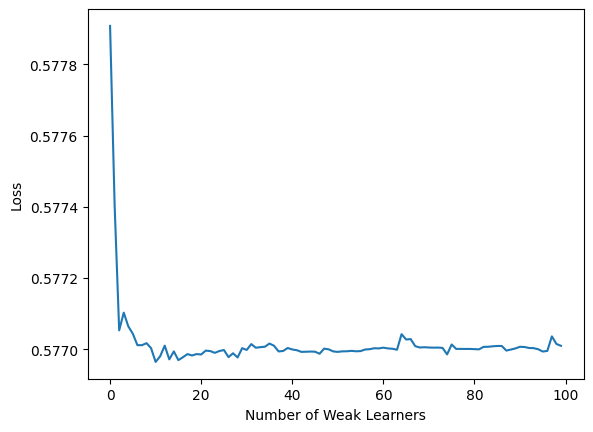

In [ ]:
plt.plot([x for x in range(100)], CLF.losses)
plt.xlabel("Number of Weak Learners")
plt.ylabel("Loss")
plt.show()

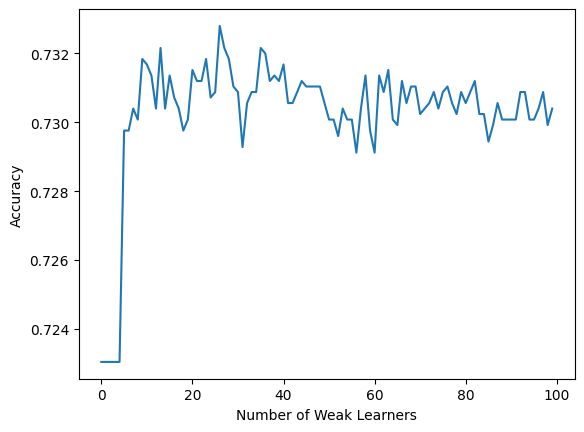

In [ ]:
plt.plot([x for x in range(100)], CLF.acc_scores)
plt.xlabel("Number of Weak Learners")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
clf = AdaBoostClassifier(25,0.01,0,'adam')
clf2 = xgb.XGBClassifier(n_estimators = 25, max_depth=6, learning_rate = 0.01)
clf3 = LogisticRegression(penalty='l2', max_iter=1000, C=1, random_state=42)

In [ ]:
# y__ = np.array(y_train)
# y_train = [[] for x in range(len(y__))]
# for x in range(len(y_train)):
#   y_train[x].append(y__[x])
# y_train = np.array(y_train)
# print(y_train, y_train.shape)

In [ ]:
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
clf.fit(X_train, y_train)

Training Loop completed: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [ ]:
y_pred = clf.predict(X_train).detach()
train_accuracy_score = accuracy_score(y_train, y_pred)
print("AdaBoost Training accuracy:", train_accuracy_score)
y_pred = clf.predict(X_val).detach()
val_accuracy_score = accuracy_score(y_val, y_pred)
print("AdaBoost Validation accuracy:", val_accuracy_score)
y_pred = clf.predict(X_test).detach()
test_accuracy_score = accuracy_score(y_test, y_pred)
print("AdaBoost Testing accuracy:", test_accuracy_score)

AdaBoost Training accuracy: 0.7248266666666666
AdaBoost Validation accuracy: 0.72032
AdaBoost Testing accuracy: 0.71376


In [ ]:
y_pred = clf2.predict(X_train)
train_accuracy_score = accuracy_score(y_train, y_pred)
print("XGBoost Training accuracy:", train_accuracy_score)
y_pred = clf2.predict(X_val)
val_accuracy_score = accuracy_score(y_val, y_pred)
print("XGBoost Validation accuracy:", val_accuracy_score)
y_pred = clf2.predict(X_test)
test_accuracy_score = accuracy_score(y_test, y_pred)
print("XGBoost Testing accuracy:", test_accuracy_score)

XGBoost Training accuracy: 0.6671733333333333
XGBoost Validation accuracy: 0.6464
XGBoost Testing accuracy: 0.63824


In [ ]:
y_pred = clf3.predict(X_train)
train_accuracy_score = accuracy_score(y_train, y_pred)
print("Logistic Regression Training accuracy:", train_accuracy_score)
y_pred = clf3.predict(X_val)
val_accuracy_score = accuracy_score(y_val, y_pred)
print("Logistic Regression Validation accuracy:", val_accuracy_score)
y_pred = clf3.predict(X_test)
test_accuracy_score = accuracy_score(y_test, y_pred)
print("Logistic Regression Testing accuracy:", test_accuracy_score)

Logistic Regression Training accuracy: 0.7249066666666667
Logistic Regression Validation accuracy: 0.72048
Logistic Regression Testing accuracy: 0.71408


In [ ]:
y_pred = clf.predict(X_train).detach()
train_accuracy_score = classification_report(y_train, y_pred)
print("AdaBoost Training report:", train_accuracy_score)
y_pred = clf.predict(X_val).detach()
val_accuracy_score = classification_report(y_val, y_pred)
print("AdaBoost Validation report:", val_accuracy_score)
y_pred = clf.predict(X_test).detach()
test_accuracy_score = classification_report(y_test, y_pred)
print("AdaBoost Testing report:", test_accuracy_score)

AdaBoost Training report:               precision    recall  f1-score   support

           0       0.72      0.73      0.73     18843
           1       0.72      0.72      0.72     18657

    accuracy                           0.72     37500
   macro avg       0.72      0.72      0.72     37500
weighted avg       0.72      0.72      0.72     37500

AdaBoost Validation report:               precision    recall  f1-score   support

           0       0.70      0.73      0.72      3029
           1       0.74      0.71      0.72      3221

    accuracy                           0.72      6250
   macro avg       0.72      0.72      0.72      6250
weighted avg       0.72      0.72      0.72      6250

AdaBoost Testing report:               precision    recall  f1-score   support

           0       0.72      0.71      0.71      3128
           1       0.71      0.72      0.72      3122

    accuracy                           0.71      6250
   macro avg       0.71      0.71      0.71      

In [ ]:
y_pred = clf2.predict(X_train)
train_accuracy_score = classification_report(y_train, y_pred)
print("XGBoost Training report:", train_accuracy_score)
y_pred = clf2.predict(X_val)
val_accuracy_score = classification_report(y_val, y_pred)
print("XGBoost Validation report:", val_accuracy_score)
y_pred = clf2.predict(X_test)
test_accuracy_score = classification_report(y_test, y_pred)
print("XGBoost Testing report:", test_accuracy_score)

XGBoost Training report:               precision    recall  f1-score   support

           0       0.65      0.71      0.68     18843
           1       0.68      0.62      0.65     18657

    accuracy                           0.67     37500
   macro avg       0.67      0.67      0.67     37500
weighted avg       0.67      0.67      0.67     37500

XGBoost Validation report:               precision    recall  f1-score   support

           0       0.62      0.70      0.66      3029
           1       0.68      0.60      0.64      3221

    accuracy                           0.65      6250
   macro avg       0.65      0.65      0.65      6250
weighted avg       0.65      0.65      0.65      6250

XGBoost Testing report:               precision    recall  f1-score   support

           0       0.63      0.69      0.65      3128
           1       0.65      0.59      0.62      3122

    accuracy                           0.64      6250
   macro avg       0.64      0.64      0.64      625

In [ ]:
y_pred = clf3.predict(X_train)
train_accuracy_score = classification_report(y_train, y_pred)
print("Logistic Regression Training report:", train_accuracy_score)
y_pred = clf3.predict(X_val)
val_accuracy_score = classification_report(y_val, y_pred)
print("Logistic Regression Validation report:", val_accuracy_score)
y_pred = clf3.predict(X_test)
test_accuracy_score = classification_report(y_test, y_pred)
print("Logistic Regression Testing report:", test_accuracy_score)

Logistic Regression Training report:               precision    recall  f1-score   support

           0       0.73      0.73      0.73     18843
           1       0.72      0.72      0.72     18657

    accuracy                           0.72     37500
   macro avg       0.72      0.72      0.72     37500
weighted avg       0.72      0.72      0.72     37500

Logistic Regression Validation report:               precision    recall  f1-score   support

           0       0.70      0.73      0.72      3029
           1       0.74      0.71      0.72      3221

    accuracy                           0.72      6250
   macro avg       0.72      0.72      0.72      6250
weighted avg       0.72      0.72      0.72      6250

Logistic Regression Testing report:               precision    recall  f1-score   support

           0       0.72      0.71      0.71      3128
           1       0.71      0.72      0.72      3122

    accuracy                           0.71      6250
   macro avg    

In [ ]:
learningRates = [.1,.01,.001]
maxIteration = [5, 25, 50]
optimizer = ["adam", "SGD"]
y_train = np.load('/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/y_train.npy')
y_val = np.load('/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/y_val.npy')
train_type=["SA", "SCR", "LA", "LCR"]

results = []

for opt in optimizer:
  for epoch in maxIteration:
    for lr in learningRates:
      for i in range(0, len(datasets_train)):
        model = AdaBoostClassifier(epoch,lr,0,opt)
        print("")
        print(str(opt) + "_" + str(epoch) + "_" + str(lr) + "_" + train_type[i])
        train_path = datasets_train[i]
        val_path = datasets_val[i]
        X_train = np.load(train_path)
        X_val = np.load(val_path)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val).detach()
        f1 = f1_score(y_val, y_pred)

        results.append([str(opt) + "_" + str(epoch) + "_" + str(lr), f1])
        torch.save(model, "/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/Adaboost_trained_models/" + str(opt) + "_" + str(epoch) + "_" + str(lr) + "_" + train_type[i])




adam_5_0.1_SA
Training Loop completed: 0 1 2 3 4 
adam_5_0.1_SCR
Training Loop completed: 0 1 2 3 4 
adam_5_0.1_LA
Training Loop completed: 0 1 2 3 4 
adam_5_0.1_LCR
Training Loop completed: 0 1 2 3 4 
adam_5_0.01_SA
Training Loop completed: 0 1 2 3 4 
adam_5_0.01_SCR
Training Loop completed: 0 1 2 3 4 
adam_5_0.01_LA
Training Loop completed: 0 1 2 3 4 
adam_5_0.01_LCR
Training Loop completed: 0 1 2 3 4 
adam_5_0.001_SA
Training Loop completed: 0 1 2 3 4 
adam_5_0.001_SCR
Training Loop completed: 0 1 2 3 4 
adam_5_0.001_LA
Training Loop completed: 0 1 2 3 4 
adam_5_0.001_LCR
Training Loop completed: 0 1 2 3 4 
adam_25_0.1_SA
Training Loop completed: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
adam_25_0.1_SCR
Training Loop completed: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
adam_25_0.1_LA
Training Loop completed: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
adam_25_0.1_LCR
Training Loop completed: 0 1 2 3 4 5 6 7 8 9 1

In [ ]:
index = 0
for i in range (0, len(results)):
  tt = train_type[index]
  index = (index + 1) % 4
  results[i].append(tt)

In [ ]:
np.save("/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/Adaboost_trained_models/F1_Scores.npy", results)

In [ ]:
top_f1 = sorted(results, key=lambda tup: tup[1], reverse=True)[:10]

In [ ]:
top_f1

[['adam_25_0.1', 0.7498029323663881, 'LA'],
 ['adam_50_0.1', 0.749488913351156, 'LA'],
 ['adam_5_0.1', 0.7484276729559748, 'LA'],
 ['adam_25_0.01', 0.7416614222781623, 'LA'],
 ['adam_50_0.1', 0.7394509803921568, 'SA'],
 ['adam_50_0.01', 0.7386990077177509, 'LA'],
 ['adam_25_0.1', 0.7370405278039586, 'SA'],
 ['adam_50_0.001', 0.7355613737871554, 'LA'],
 ['adam_5_0.1', 0.7354189592831315, 'SA'],
 ['adam_25_0.001', 0.7331378299120235, 'LA']]

In [ ]:
train_type={"SA": 0, "SCR": 1, "LA": 2, "LCR": 3}
y_test = np.load('/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/y_test.npy')
for mod in top_f1:
  i = train_type[mod[2]]
  test_path = datasets_test[i]
  X_test = np.load(test_path)
  model = torch.load("/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/Adaboost_trained_models/" + mod[0] + "_" + mod[2])
  y_pred = model.predict(X_test).detach()

  accuracy = classification_report(y_test, y_pred)
  print(mod[0])
  print(accuracy)



adam_25_0.1
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      3128
           1       0.74      0.73      0.74      3122

    accuracy                           0.74      6250
   macro avg       0.74      0.74      0.74      6250
weighted avg       0.74      0.74      0.74      6250

adam_50_0.1
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      3128
           1       0.74      0.74      0.74      3122

    accuracy                           0.74      6250
   macro avg       0.74      0.74      0.74      6250
weighted avg       0.74      0.74      0.74      6250

adam_5_0.1
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      3128
           1       0.74      0.74      0.74      3122

    accuracy                           0.74      6250
   macro avg       0.74      0.74      0.74      6250
weighted avg       0.74      0.74      

In [ ]:
results = np.load("/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/Adaboost_trained_models/F1_Scores.npy")
top_models = sorted(results, key=lambda tup: tup[1], reverse=True)

In [ ]:
y_train = np.load('/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/y_train.npy')
y_val = np.load('/content/drive/MyDrive/Applied Machine Learning/Project Milestone 2/y_val.npy')
train_index={"SA": 0, "SCR": 1, "LA": 2, "LCR": 3}

model_names = []
cost = []
accuracy = []

for i in [0,1,2,3,4,50]:
  parameters = top_models[i][0].split("_")
  data_type = train_index[top_models[i][2]]
  train_path = datasets_train[data_type]
  val_path = datasets_val[data_type]
  X_train = np.load(train_path)
  X_val = np.load(val_path)
  model = AdaBoostClassifier(int(parameters[1]),float(parameters[2]),0,parameters[0], X_val, y_val)
  model.fit(X_train, y_train)
  cost.append(model.losses)
  accuracy.append(model.acc_scores)
  model_names.append(top_models[i][0].upper())


Training Loop completed: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 Training Loop completed: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 Training Loop completed: 0 1 2 3 4 Training Loop completed: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 Training Loop completed: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 Training Loop completed: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

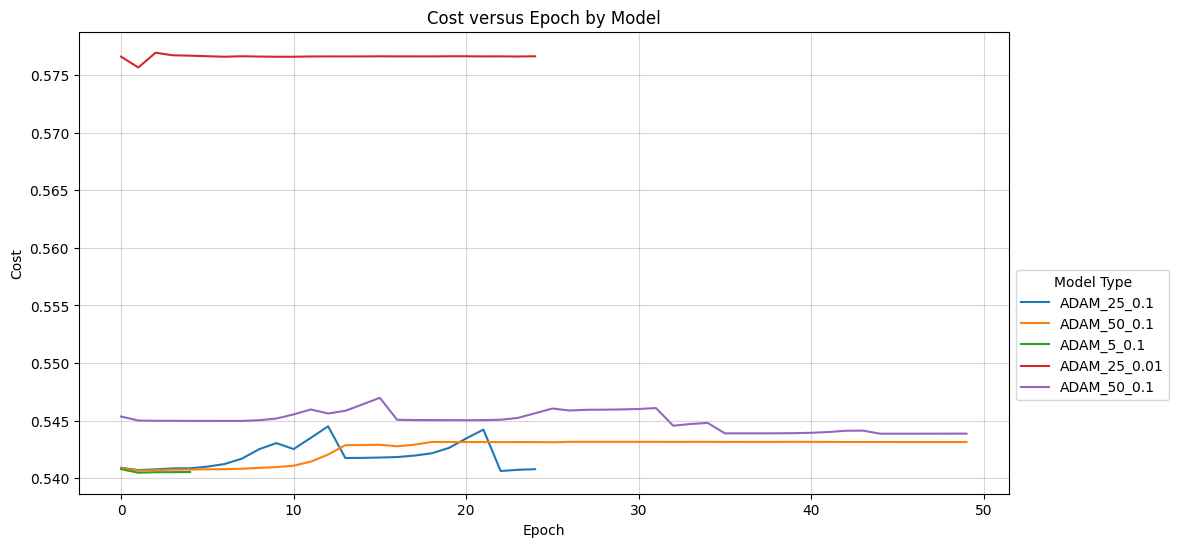

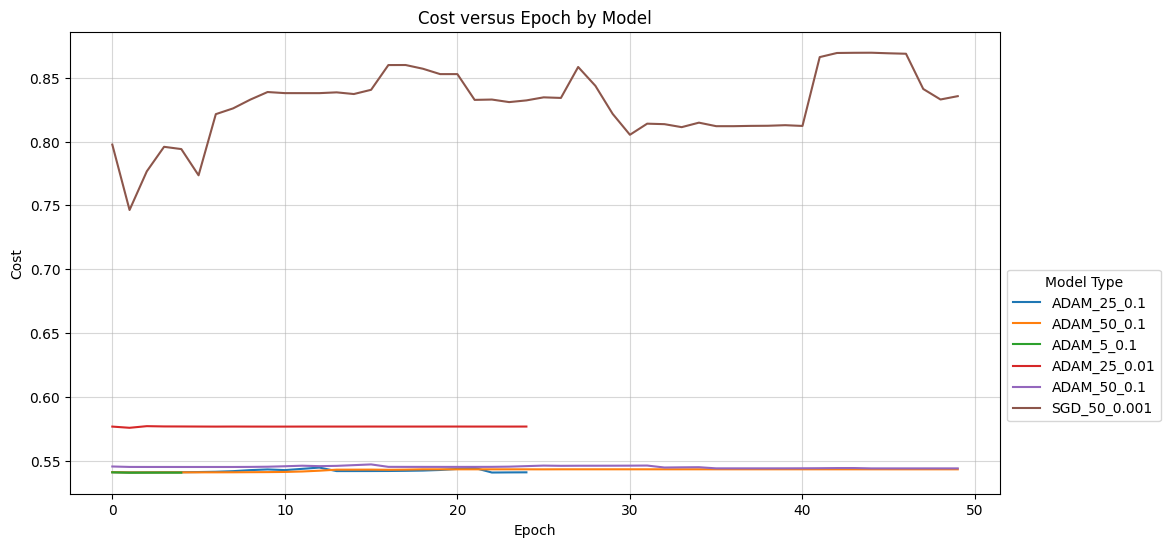

In [ ]:
# Plot without SGD
fig, ax = plt.subplots()

for i in range(0, len(model_names)-1):
  c = cost[i]
  iterations = np.arange(0, len(c))
  ax.plot(iterations, c, linestyle='solid', label = model_names[i])

ax.legend(title="Model Type", loc="upper left", bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Epoch")
ax.set_ylabel("Cost")
plt.grid(alpha=0.5)
fig.set_size_inches(12, 6)
plt.title("Cost versus Epoch by Model")
plt.show()

# Plot with SGD
fig, ax = plt.subplots()

for i in range(0, len(model_names)):
  c = cost[i]
  iterations = np.arange(0, len(c))
  ax.plot(iterations, c, linestyle='solid', label = model_names[i])

ax.legend(title="Model Type", loc="upper left", bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Epoch")
ax.set_ylabel("Cost")
plt.grid(alpha=0.5)
fig.set_size_inches(12, 6)
plt.title("Cost versus Epoch by Model")
plt.show()

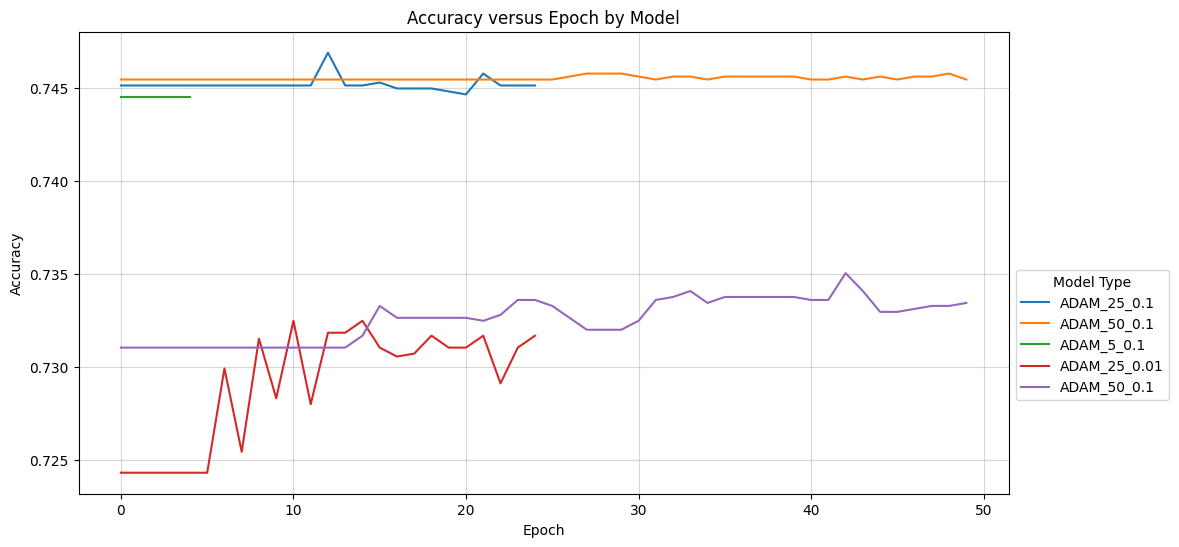

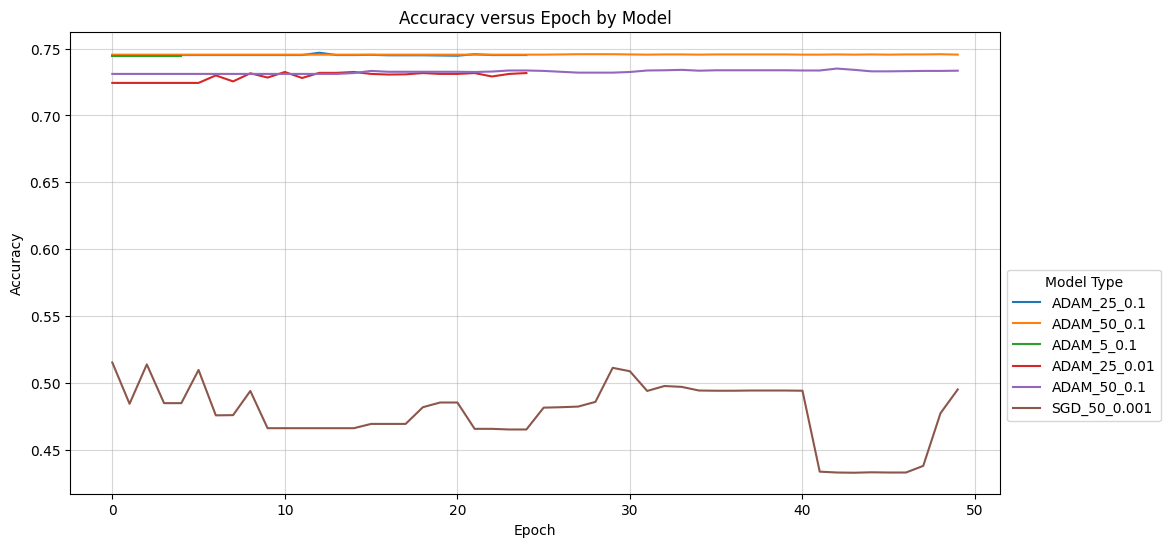

In [ ]:
# Plot without SGD
fig, ax = plt.subplots()

for i in range(0, len(model_names)-1):
  c = accuracy[i]
  iterations = np.arange(0, len(c))
  ax.plot(iterations, c, linestyle='solid', label = model_names[i])

ax.legend(title="Model Type", loc="upper left", bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
plt.grid(alpha=0.5)
fig.set_size_inches(12, 6)
plt.title("Accuracy versus Epoch by Model")
plt.show()

# Plot with SGD
fig, ax = plt.subplots()

for i in range(0, len(model_names)):
  c = accuracy[i]
  iterations = np.arange(0, len(c))
  ax.plot(iterations, c, linestyle='solid', label = model_names[i])

ax.legend(title="Model Type", loc="upper left", bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
plt.grid(alpha=0.5)
fig.set_size_inches(12, 6)
plt.title("Accuracy versus Epoch by Model")
plt.show()